In [16]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.

| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead)
| YrFireName                  | Year and name of the fire.                                    
| Times_burned                | The number of times this tree was burned                                           
| Species                     |  Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number                                                   
| Genus_species               |  Genus and species of tree                                     
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters). NA = not assessed.
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters). NA = not assessed
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.


## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [17]:
# Load the dataset and keep following columns
trees_dat = pd.read_csv('data/FTM_trees.csv', usecols=['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post'])

# Drop NAs
trees_dat = trees_dat.dropna()
trees_dat.isna().sum()

YrFireName       0
Species          0
Times_burned     0
Genus_species    0
DBH_cm           0
HT_m             0
CR_pre           0
yr1status        0
CR_post          0
dtype: int64

In [18]:
# View new data frame
trees_dat

,YrFireName,Species,Times_burned,Genus_species,DBH_cm,HT_m,CR_pre,yr1status,CR_post
500,2003 - Griff,ABAM,1,Abies_amabilis,71.374,41.76,0.84,0.0,0.74
501,2003 - Griff,ABAM,1,Abies_amabilis,23.622,12.80,0.60,0.0,0.57
502,2003 - Griff,ABAM,1,Abies_amabilis,46.228,34.75,0.75,0.0,0.59
503,2003 - Griff,ABAM,1,Abies_amabilis,21.082,23.16,0.38,0.0,0.38
504,2003 - Griff,ABAM,1,Abies_amabilis,24.384,26.21,0.42,0.0,0.42
...,...,...,...,...,...,...,...,...,...
169332,2003 - B and B,TSME,1,Tsuga_mertensiana,32.512,15.54,0.90,0.0,0.90
169333,2003 - B and B,TSME,1,Tsuga_mertensiana,24.892,14.63,0.81,0.0,0.81
169334,2003 - B and B,TSME,1,Tsuga_mertensiana,32.258,16.46,0.85,0.0,0.63
169335,2003 - B and B,TSME,1,Tsuga_mertensiana,31.750,18.59,0.87,0.0,0.80


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [19]:
# Function to convert categorical variables to numerical
for col in ['Genus_species', 'YrFireName', 'Species']:
    trees_dat[col] = trees_dat[col].astype('category').cat.codes

In [20]:
# View df to check 
trees_dat.dtypes

YrFireName          int8
Species             int8
Times_burned       int64
Genus_species       int8
DBH_cm           float64
HT_m             float64
CR_pre           float64
yr1status        float64
CR_post          float64
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [21]:
# Assign predictor and outcome variables
X = trees_dat[['Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post', 'YrFireName']]
y = trees_dat['yr1status']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
...

Ellipsis

3. How many training/test observations do we have? Print your answer in the cell below. 

In [22]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [23]:
# Create logistic regression classifier
model_log = LogisticRegression()

# Fit model onto training data
model_log.fit(X_train_scaled, y_train)

# Make predictions on training data
y_train_pred = model_log.predict(X_train_scaled)

# Calculate training accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)

# Print training accuracy
print(f"Training Accuracy: {accuracy_train:.2f}")

Training Accuracy: 0.95


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.94
[[9838  195]
 [ 460  460]]


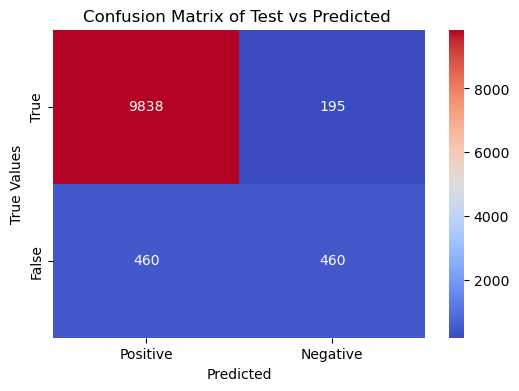

In [24]:
...
# Make predictions on test data
y_test_pred = model_log.predict(X_test_scaled)

# Calculate test accuracy
accuracy_test = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy_test:.2f}")

# Extract probabilities of distribution for confusion matrix
y_probs = model_log.predict_proba(X_test_scaled)[:, 1]

# Make Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'coolwarm',
            xticklabels=['Positive', 'Negative'], yticklabels = ['True', 'False'])
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.title('Confusion Matrix of Test vs Predicted ')
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

In [25]:
# Calculate true positive, 
TP = cm[0,0]   # True positive is in position 1,1 on matrix
TN = cm[1,1]    # True negative
FP = cm[0,1]    # False positive
FN = cm[1,0]    # False Negative


# Calculate sensitivity and specificity 
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)


print(sensitivity)
print(specificity)

0.955331132258691
0.7022900763358778


The model performed well on the test data with a 94% accuracy of correctly predicting dead trees. The model does perform differently on observations from trees that died vs survived as we have a sensitivity value of 0.95 and a specificity value of 0.70. These values are essentially an accuracy value for trees that survived versus trees that died. Yes, there is a class imbalance within the data set as there are almost 10,000 observations of dead trees, with less than a 1000 observations of survived trees. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

If we had a model that always predicted majority class then it might not be entirely trustworthy. If the model was tested on fire data consisting of dead trees, then it would probably have a high accuracy. On the other hand, if it was given normal tree data, then it might not estimate properly. A logistic regression model will better take into account the minority classes. 

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [26]:
# Classify majority model
model = DummyClassifier(strategy = 'most_frequent')

# Fit model onto training data
model.fit(X_train_scaled, y_train)

# Make predictions on test data
y_pred = model.predict(X_test_scaled)

# Calculate probability of distribution
y_probs_dummy = model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy
dummy_accuracy = accuracy_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_accuracy:.2f}")
print("\nDummy Confusion Matrix:", cm)


Dummy Accuracy: 0.92

Dummy Confusion Matrix: [[10033     0]
 [  920     0]]


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [27]:
# Logistic classifier AUC
logit_auc = roc_auc_score(y_test, y_probs)

print(f"Logistic AUC: {logit_auc:.3f} ")

# Create roc_curve for logit model 
fpr_log, tpr_log, thresholds = roc_curve(y_test, y_probs)

Logistic AUC: 0.918 


In [28]:
# Dummy classifier AUC
dummy_auc = roc_auc_score(y_test, y_probs_dummy)

print(f"Dummy AUC: {dummy_auc}")

# Create roc_curve for dummy model
fpr_dummy, tpr_dummy, thresholds = roc_curve(y_test, y_probs_dummy)

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

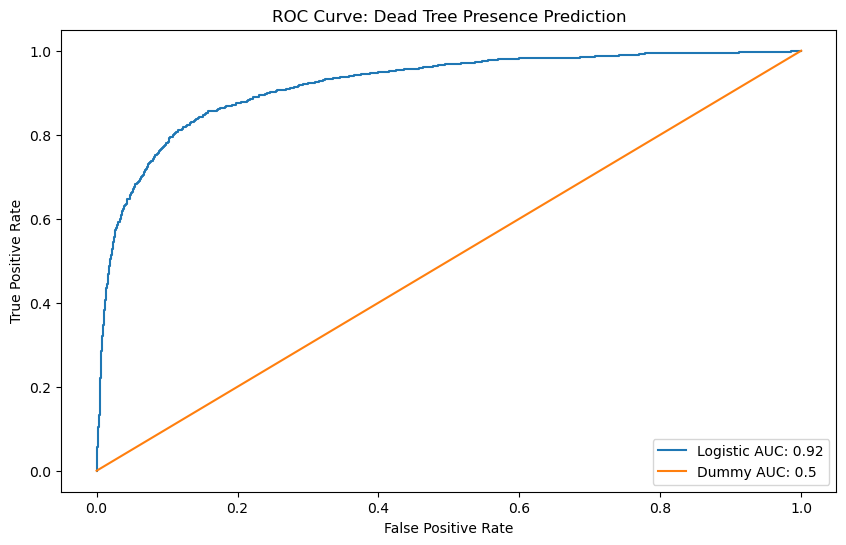

In [29]:
# Initialize plot
plt.figure(figsize = (10, 6))

# Plot ROC curves
plt.plot(fpr_log, tpr_log, label = f"Logistic AUC: {logit_auc:.2f}")
plt.plot(fpr_dummy, tpr_dummy, label = f"Dummy AUC: {dummy_auc}")

# Plot Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Dead Tree Presence Prediction')

plt.legend(loc = 'lower right')

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The models have very different AUC scores. An AUC score indicates that the model is not learning from the data. It is basically "guessing" whether or not a tree is dead. Accuracy isn't always the best thing to base our models off because we can see that we had a high accuracy of 0.92 for our dummy model, but a very low AUC. It is always good to use both metrics to interpret the model. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [30]:
# Define coefficients
coefficients = model_log.coef_[0]

# Define features
features = X.columns


# Create a dataframe for the feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Print the sorted feature importance
print(importance_df)

         Feature  Coefficient
0   Times_burned     0.000000
1        Species     0.541509
2  Genus_species    -0.067867
3         DBH_cm     0.421324
4           HT_m    -1.165414
5         CR_pre     0.123414
6        CR_post    -2.494974
7     YrFireName    -0.660497


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The features that have the largest magnitude are CR_post and HT_m with values of -2.49 and -1.17 respectively. As `CR_post` is the post fire live crown ratio and `HT_m` is the height of the tree in meters, the negative coefficients of these values indicate that there is a higher probability for trees to be dead as these values go down. This means that having a higher tree height and crown ratio coefficient indicate having fewer trees that die one year after the fire. It is hard to implement management strategies for this, but we would want to optimize how fast these trees can grow, so they have better resilience against wildfires. 